Quantum demo, by David Finder.

Howdy, welcome to the quantum demo. We're going to work with _baby_ RSA and _baby_ Shor's algorithm.


First, we're going to cover RSA.

RSA is an asymmetric encryption scheme commonly used for web traffic. Asymmetric means that we can have separate public and private keys. Public key is used for encryption, private key is used for decryption. 


It relies on finding $m^{ed}\equiv m\mod n$ such that e,d, and m are large positive numbers. M is our message, e is our public key, and d is our private key. 
 

First we need to find our public and private key. 

To do this we need to find two very large prime numbers....

In [6]:
p = 13
q = 23

For some definition of very large. Maybe this is a graph theory class, where 7 is a large number.

In [7]:
n=p*q

N is our modulus, this is released publically. 
Next, we calculuate $\lambda(n)$, which is the Carmichael Lambda function. 

$\lambda(n) = lcm(\lambda(p),\lambda(q))$.

Given that p,q are prime, $\lambda(p),\lambda(q) = p-1,q-1$

So we take the lcm(12,22), and keep this secret. 

In [8]:
import math
l = math.lcm(p-1,q-1)
l

132

Next, we choose an integer e, less than $\lambda(n)$, such that the two are coprime. 

In [9]:
from sympy import factorint
factorint(132)
e=5

5 looks like a good value for e. 

Next we determine $d\equiv e^{-1}\mod\lambda(n)$


In [10]:
d=[x for x in range(0,132) if (x*e)%l==1][0]
d

53

Note: Never make your d this small in an actual implementation. Having a small d makes you vulnerable to [Wiener's attack](https://en.wikipedia.org/wiki/Wiener%27s_attack). Now that we're done snickering:

Our public key is (n,e), and our private key is d. 

We can discard p,q, and $\lambda(n)$

In [11]:
public = (n,e)
private = d
print(public)
print(private)

(299, 5)
53


So give me a message using ASCII characters:

In [12]:
message = input("Please give me a plaintext:")

Please give me a plaintext: text


Because our n is so small, we're going to use an ascii encoding, and encrypt each individual value. 

In [13]:
ascii_values = list(map(lambda x: ord(x),message))

In [14]:
ascii_values

[116, 101, 120, 116]

And now to encrypt, we take each of these integers, and take: $c=m^e \mod(n)$

In [15]:
cypher_text = list(map(lambda x: (x**e)%n, ascii_values))
print("".join(list(map(lambda x: chr(x),cypher_text))))
cypher_text


tîÌt


[116, 238, 204, 116]

beautiful

Now to decrypt, we do the same thing again, with our D private key.

In [16]:
uncypher_text = list(map(lambda x: (x**d)%n, cypher_text))
print(uncypher_text)
print("".join(list(map(lambda x: chr(x),uncypher_text))))

[116, 101, 120, 116]
text


The magic here stems from the fact that working in addition mod $\lambda (n)$, is equivalent to working in multiplication mod n. 

In particular: $m^{ed} = m^{1+h*\lambda(n)} \mod n$ for some h, because $ed=1 \mod \lambda(n)$ 

We know from Carmichael theorem, that $m^{\lambda(n)}\equiv1$ mod n, which gives us $m^{ed} = m*(e^{\lambda(n)})^h \equiv m*1^h \equiv m$



This is gives us a small problem though.... If we can factor n, which is public, we can find p,q, thus l, and then $\lambda(n)$, which allows us to find d from e by Chinese Remainder theorem. 

Fortunately, factoring numbers is computationally hard. 

The largest we've been able to factor is [RSA-250](https://web.archive.org/web/20200228234716/https://lists.gforge.inria.fr/pipermail/cado-nfs-discuss/2020-February/001166.html)

Which took about 2700 core years for a number with 829 bits. The researchers estimated that a 1024 RSA modulus would take about 500 times as long.[Source](https://eprint.iacr.org/2010/006.pdf). 

These days, 2048 bit modulus are needed. 
Factoring numbers takes sub-exponentially longer with the more bits you add, so with classical computing, we would be in a losing battle against a larger key size. 

Enter quantum computing and shors algorithm. 

So we're going to go through the cool demonstration first and then piece together how it works

In [61]:
from braket.aws import AwsDevice
from braket.experimental.algorithms.shors.shors import (
    shors_algorithm,
    run_shors_algorithm,
    get_factors_from_results,
    _get_phases
)

# AWS imports: Import Braket SDK modules
from braket.aws import AwsDevice, AwsQuantumTask
from braket.circuits import Circuit, Gate, observables
from braket.device_schema import DeviceActionType
from braket.devices import Devices, LocalSimulator
from braket.parametric import FreeParameter


So first we're going to run this in a simulation, because that's the easy part.

In [40]:
a = 8  # Any integer that satisfies 1 < a < N and gcd(a, N) = 1.
shors_circuit = shors_algorithm(n, a)
managed_sim = AwsDevice("arn:aws:braket:::device/quantum-simulator/amazon/sv1")
output = run_shors_algorithm(shors_circuit, managed_sim)
guessed_factors = get_factors_from_results(output, 299, 8)

Number of Measured phases (s/r) : 4

For phase 0.75 :
Estimate for r is : 4
Factors are : 1 and 13

For phase 0.5 :
Estimate for r is : 2
Factors are : 1 and 1

For phase 0.0 :
Estimate for r is : 1
Factors are : 299 and 1

For phase 0.25 :
Estimate for r is : 4
Factors are : 1 and 13


Non-trivial factors found are : {13}


So that was the factorizaiton of 299 on a simulated quantum computer. It was very nice, and it did a lot of magic, which I'm going to have to explain. 

First things first, my choice of A was a bit of a backwards rationalization, all the other prior numbers that were valid didn't work. 


Lets do a quick runthrough of how this actually works by doing a code dive.
What _is_ shors Algorithm?

[Well, here's our sample code](https://github.com/amazon-braket/amazon-braket-algorithm-library/blob/main/src/braket/experimental/algorithms/shors/shors.py)

Overview of the circuits main steps:

0. We make an input register of sufficient capacity to store n with k qubits. We put those qubits into the hadamard basis, representing all of those 2^k states at once. 


1. "a" is used to generate a function circuit, which takes x and spits out a^x mod 15. in this case, we represent 8^x mod 15. This is actually a relatively simple task because given x as a binary number, (a=8)^x mod 15. 

This function will apply to a target set of auxillary qubits. 

How is this implemented?
![alt text](./Code.png "Title")

very slowly, it seems!

For each counting qubit, we apply $O(2^i)$ gates. 

hold on, I think I just lost my previous plot. 
I have concluded that this implementation of shors algorithm is bogus. It uses an equal number of auxillary qubits to its normal qubits.


dict_values([71, 54, 73, 74, 60, 56, 65, 47, 69, 74, 68, 43, 53, 63, 75, 55])
9
['0b0', '0b0', '0b100000000', '0b10000000', '0b100000000', '0b110000000', '0b100000000', '0b10000000', '0b0', '0b100000000', '0b0', '0b10000000', '0b110000000', '0b110000000', '0b10000000', '0b110000000']
[0.75, 0.5, 0.0, 0.25]


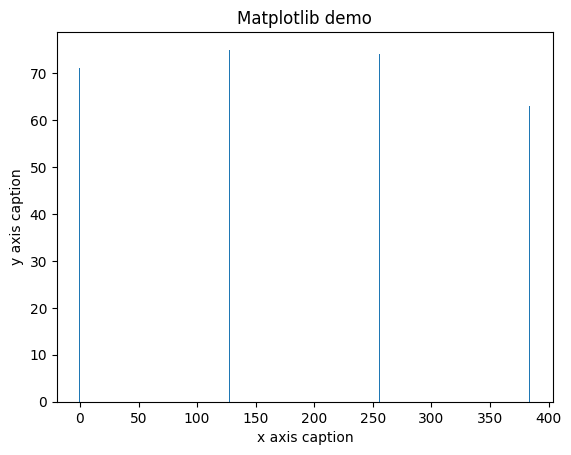

In [68]:
import numpy as np
print(output['measurement_counts'].values())
n = int(np.ceil(np.log2(299)))
print(n)
print(list(map(lambda x: bin(int(x[:9],2)),output['measurement_counts'].keys())))
from matplotlib import pyplot as plt 
print(_get_phases(output['measurement_counts']))
plt.title("Matplotlib demo") 
plt.xlabel("x axis caption") 
plt.ylabel("y axis caption") 
plt.bar(list(map(lambda x: int(x[:9],2),output['measurement_counts'].keys())),output['measurement_counts'].values())
plt.show()

In [38]:
from qiskit_braket_provider import BraketProvider

provider = BraketProvider()
aquila = AwsDevice(Devices.QuEra.Aquila)
aquila.run(shors_circuit,shots=1000)

ValidationException: An error occurred (ValidationException) when calling the CreateQuantumTask operation: Device arn:aws:braket:us-east-1::device/qpu/quera/Aquila supports ['braket.ir.ahs.program'] action type, but the supplied action type is braket.ir.openqasm.program

In [22]:
from qiskit_braket_provider import BraketProvider

provider = BraketProvider()

rigetti = AwsDevice(Devices.Rigetti.Ankaa2)
print(rigetti.queue_depth())
print(rigetti)
rigetti.run(shors_circuit,shots=1000)

QueueDepthInfo(quantum_tasks={<QueueType.NORMAL: 'Normal'>: '0', <QueueType.PRIORITY: 'Priority'>: '0'}, jobs='0')
Device('name': Ankaa-2, 'arn': arn:aws:braket:us-west-1::device/qpu/rigetti/Ankaa-2)


DeviceOfflineException: An error occurred (DeviceOfflineException) when calling the CreateQuantumTask operation: Device is not available. Status = OFFLINE

In [ ]:
iqm = AwsDevice(Devices.IQM.Garnet)
print(iqm.queue_depth())
output = iqm.run(shors_circuit, shots=1000)
#output = run_shors_algorithm(shors_circuit, iqm)

Okay, so what do I want to do:

make a tiny printout of the circuit

explain how each of the components work

make a run through of the underlying math

provide some choice selection for which AWS device to use

email notification


output

In [ ]:
output

In [ ]:
output.queue_position()


In [5]:
print(iqm.queue_depth())

QueueDepthInfo(quantum_tasks={<QueueType.NORMAL: 'Normal'>: '10', <QueueType.PRIORITY: 'Priority'>: '0'}, jobs='0')


In [4]:
iqm = AwsDevice(Devices.IQM.Garnet)